# Fits over Directory
Run analysis procedures over directory to get fits and plots. Probably have to do manual labour but lets see...

In [2]:
#importing directories
from random import gauss
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
from astropy.io import ascii
import GetLightcurves as gc
from transit import occultnonlin, occultquad

Global Constants over entire code

In [3]:
rv_entry=ascii.read('../../Catalogs/robovetter_label.dat')
rv_pl=np.array(rv_entry['tce_plnt_num'])
rv_label = rv_entry['label']
rv_kepid=[('0000'+str(el)[:9])[-9:] for el in rv_entry['kepid']]
av_entry=ascii.read('../../Catalogs/autovetter_label.tab')
av_pl=np.array(av_entry['tce_plnt_num'])
av_label = av_entry['av_training_set']
av_kepid=[('0000'+str(el)[:9])[-9:] for el in av_entry['kepid']]
av_time=av_entry['tce_duration']
av_p=av_entry['tce_period']
av_timeerr=av_entry['tce_duration_err']

Fitting Functions: Gaussian, Lorentzian, Planet Transit

In [4]:
def gausses(x, A1, m1, s1, A2, m2, s2):
    y = A1*np.exp(-(x-m1)**2/(2*s1**2)) + A2*np.exp(-(x-m2)**2/(2*s2**2))
    return(y)

def lorz(x,A1,x0,g, A2, x02, g2):
    y = A1 / (1*((x-x0)**2+(g/2)**2)) + A2 / (1*((x-x02)**2+(g2/2)**2))
    return(y)

def new_plar(ph,p,minus, plus,rorb):
    u1 = (plus + minus)/2
    u2 = (plus - minus)/2
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_free(ph,p,u1,plus,rorb):
    u2 = plus - u1
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_free2(ph,p,u1,u2,rorb):
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2,])  
    return(a -1) 


### Fitting Model (Mandel and Algol 2002)

Run through directory to fit model to the lightcurves: The ones that dont fit properly are in the problist section, may have to approach them manually. 

In [10]:
#entries = os.listdir('../../processed_directories/go_circles/find_circles_rel/')
entries = np.loadtxt('../../processed_directories/go_circles/problem_nonfits', delimiter=' ', dtype='str')
print(len(entries))
#np.random.shuffle(entries)
problist=[]
for el in entries:
    
    df = pd.read_csv('../../processed_directories/go_circles/find_circles_rel/'+el+'.csv')
    flux = np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))])
    fluxg = np.array([ x for x in df['flux_g'] if(not(np.isnan(x)))])
    phase = np.array(df['phase_l'])[:len(flux)]
    phaseg= np.array(df['phase_g'])[:len(fluxg)]
    #print(min(phaseg), max(phaseg))
   
    try: popt1,pcov1=curve_fit(new_plar_free2, phase, flux, bounds=([0.00001,-1,0,1], [1,1,1,200]))
    except: 
        print("no fit")
        problist.append(el[:11])
        continue
  
    
    print(el[:9],":",np.round(np.trace(pcov1),3),'ptd: ',np.round(popt1[0],5), 
        np.round((popt1[1]),3), np.round((popt1[2]),3), np.round(popt1[3],3))
     
    if(popt1[1]>0.9999 or popt1[2]>0.9999):
        problist.append(el[:11])
        print('overboard')
        continue
    #if(popt1[3]<10.001):
    #    problist.append(el[:11])
    #    print('under rad')
    #    continue
    if(np.trace(pcov1)>100):
        print("fit variance")
        problist.append(el[:11])
        continue
    dfg = pd.DataFrame(zip(phaseg,fluxg, new_plar_free2(np.array(phaseg), *popt1)),
        columns=['phase_g','flux_g','model_g'])
    dfl= pd.DataFrame(zip(phase, flux,new_plar_free2(np.array(phase), *popt1)),
        columns=[ 'phase_l', 'flux_l','model_l'])
    df1 = [dfl, dfg]
    df1 = pd.concat(df1, axis=1)

    store = pd.HDFStore('../../processed_directories/go_circles/temp2/'+el[:11])
    store.put('data', df1)
    store.get_storer('data').attrs.metadata = {'attr':popt1, 
        'var':np.trace(pcov1)}
    store.close()

#np.savetxt('../../processed_directories/go_circles/list_of_nonfits',problist,delimiter=' ',fmt="%s")

4029
000757450 : 23.79 ptd:  0.10139 1.0 0.172 64.894
overboard


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


001025986 : 4613836497.412 ptd:  0.0078 0.997 0.009 143.578
fit variance
001026957 : 1.759 ptd:  0.02486 1.0 0.733 199.991
overboard
001161345 : 21.681 ptd:  0.02014 0.108 0.0 134.812
001431122 : 113244.118 ptd:  0.01442 -0.089 0.281 134.225
fit variance
001432789 : 11042.114 ptd:  0.02065 -0.697 0.036 127.621
fit variance
001432789 : 66.024 ptd:  0.01053 0.04 0.029 132.149
001717722 : 85.988 ptd:  0.04695 1.0 1.0 200.0
overboard
001717722 : 41787.545 ptd:  0.01435 0.244 0.14 81.152
fit variance
001718189 : 9.308 ptd:  0.01549 0.342 0.0 119.666
001718189 : 15.944 ptd:  0.00936 1.0 1.0 150.154
overboard
001718958 : 432.685 ptd:  0.00825 -0.959 0.008 145.298
fit variance
001721157 : 516.438 ptd:  0.01604 -0.197 0.023 65.534
fit variance
001723078 : 47076670.844 ptd:  0.01329 -0.973 0.013 1.009
fit variance
001724719 : 341861.047 ptd:  0.01033 -0.072 0.015 55.252
fit variance
001725016 : 35.855 ptd:  0.0234 -0.967 0.006 136.598
001849702 : 7.174 ptd:  0.01214 1.0 0.994 169.929
overboard
0

[4094] 0.10981287885443204 24.269382146166258
-0.0239866264164447 0.0239902157336473
[ 0.42479079 -0.01083846  0.00089592  0.53452767  0.01002808  0.00092373] [ 0.14277209 -0.02158796  0.1         0.14277209  0.02159119  0.1       ]


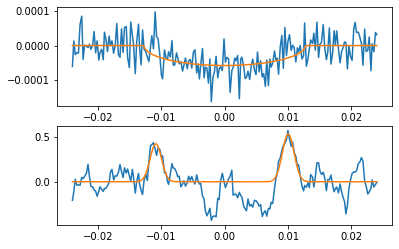

In [28]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_rel/')
el = entries[100]
store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_rel/'+el)
df = store['data']
metadata = store.get_storer('data').attrs.metadata
store.close()

loc=np.where(np.asarray(rv_kepid)==el[:9])[0]
rv_loc_f = [x for x in loc if(str(rv_pl[x])==el[10:11])]
if(len(rv_loc_f)==0): 
    print("not in catalog")


print(rv_loc_f, av_time[rv_loc_f[0]]/(24*av_p[rv_loc_f[0]]), metadata['var'])
phase = np.array([ x for x in df['phase_l'] if(not(np.isnan(x)))])
flux = np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))])
model = np.array([ x for x in df['model_l'] if(not(np.isnan(x)))])
res = np.convolve(df['flux_l']-df['model_l'], np.ones(10)/10, mode='same')
res = np.array([(el-np.median(res))/(max(res)-min(res)) for el in res])
popt1, pcov1 = curve_fit(gausses, phase, res, bounds=([max(res)/4,0.9*min(phase),0.0001,max(res)/4,0,0.0001], [max(res), 0, .1,max(res), 0.9*max(phase),.1]))
    
popt2, pcov2 = curve_fit(lorz, phase, res, bounds=([max(res)/4,0.9*min(phase),0.0001,max(res)/4,0,00.0001], [max(res), 0, .1,max(res), 0.9*max(phase), .1]))
print(min(phase),max(phase))
print(popt1, popt2)
fig, ax=plt.subplots(2,1)
ax[0].plot(df['phase_l'], df['flux_l'])
ax[0].plot(df['phase_l'], df['model_l'])
ax[1].plot(df['phase_l'], res )
ax[1].plot(phase,gausses(phase, *popt1))
#ax[1].plot(phase, lorz(phase, *popt2))
#ax[1].plot(phase, gausses(phase,0.3,-0.03,0.004,0.3,0.03,0.004))
#ax[0].set_xlim(-0.1,0.1)
#ax[1].set_xlim(-0.1,0.1)


### Finding Residuals
Fitting Gaussian/ Lorentzian Profiles to circles to see where we can get some recognisable peaks...

In [4]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_rel/')
problist=[]
for el in entries:
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_rel/'+el)
    df = store['data']
    metadata = store.get_storer('data').attrs.metadata
    store.close()

    try: 
        loc=np.where(np.asarray(rv_kepid)==el[:9])[0]
        rv_loc_f = [x for x in loc if(str(rv_pl[x])==el[10:11])]
        #print(rv_loc_f, el)
    except: 
        print("not in catalog")
        continue

    if(len(rv_loc_f)==0): 
        print("not in catalog")
        continue
   
    k = np.ones(10)/10
    flux = np.convolve(np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))]),k,mode='same')
    model = np.convolve(np.array([ x for x in df['model_l'] if(not(np.isnan(x)))]),k,mode='same')
    #flux = np.array(df['flux_l'])
    #model = np.array(df['model_l'])

    res = np.convolve(flux - model, k ,mode='same')
    phase = np.array(df['phase_l'])[:len(res)]
    try: popt1, pcov1 = curve_fit(gausses, phase, res, bounds=([max(res)/4,0.9*min(phase),0.0001,max(res)/4,0,0.0001], [max(res), 0, .1,max(res), 0.9*max(phase),.1]))
    except: 
        print("no gauss fit")
        continue
    
    print(el[:9],'ptd: ', np.abs(popt1[1]-popt1[4]))
     
    dfl = pd.DataFrame(zip(phase,flux,model,res, gausses(phase, *popt1)),
        columns=['phase_l', 'flux_l', 'model_l','residue', 'gaussian'])
    dfg = pd.DataFrame(zip(df['phase_g'],df['flux_g'],df['model_g']),
        columns=['phase_g','flux_g','model_g'])
    df1 = [dfl, dfg]
    df1 = pd.concat(df1, axis=1)
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_with_res/'+el[:11])
    store.put('data', df1)
    store.get_storer('data').attrs.metadata = {'label':rv_label[rv_loc_f[0]],'gauss':popt1,'model':metadata['attr'],
        'mod_var':metadata['var'],'gdur':np.abs(popt1[1]-popt1[4]) ,'g_cov':np.trace(pcov1)}
    store.close()


np.savetxt('../../processed_directories/go_circles/list_of_nonfits_residue',problist,delimiter=' ',fmt="%s")

001432789 ptd:  0.039160015138841535
001432789 ptd:  0.06456902891939215
not in catalog
001718958 ptd:  0.0694090223747067
001721157 ptd:  0.03154737758910253
001724719 ptd:  0.03919199781637095
001724719 ptd:  0.021728502149280057
001725016 ptd:  0.019640151281155312
001865042 ptd:  0.03209011307148063
001871056 ptd:  0.022074523682486732
001871056 ptd:  0.010111486375067286
001995519 ptd:  0.008716520323851512
001996180 ptd:  0.06451026537657994
001996180 ptd:  0.03575211955249745
002019477 ptd:  0.03515839873908011
002019477 ptd:  0.03629915575695772
002142522 ptd:  0.020581191178762608
002161536 ptd:  0.010792455575288672
002161949 ptd:  0.024677676630598853
002165002 ptd:  0.019596514105796402
002299738 ptd:  0.25965343384519235
002301068 ptd:  0.023245475974778447
002302548 ptd:  0.018870348508024395
002305866 ptd:  0.027779974827328913
002305866 ptd:  0.01076490076235444
002307415 ptd:  0.02591625200584527
002307415 ptd:  0.019763043833292734
002422820 ptd:  0.023612694028103114

### Cumulative Batch Plotting

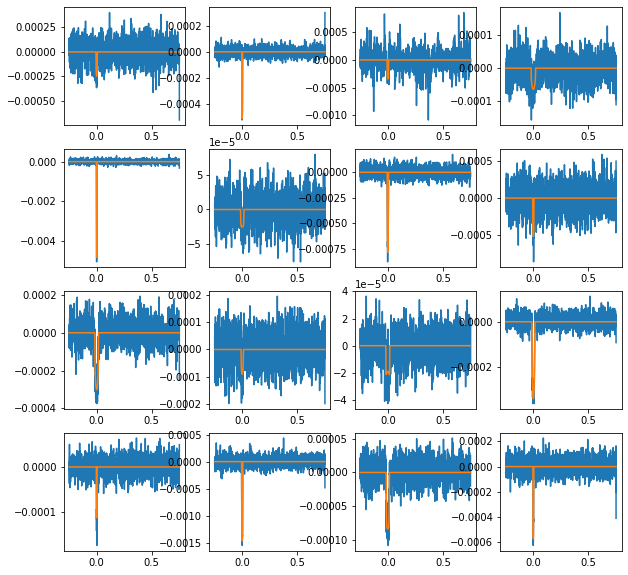

In [6]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_with_res/')
#np.loadtxt('../../processed_directories/go_circles/hot_jupiters')
np.random.shuffle(entries)
fig, axs = plt.subplots(4,4,figsize=(10,10))


for el,ax in zip(entries[:16],axs.ravel()):
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_with_res/'+el)
    df = store['data']
    metadata = store.get_storer('data').attrs.metadata
    #df = pd.read_csv('../../processed_directories/go_circles/find_circles_rel/'+el)
    ax.plot(df['phase_g'],df['flux_g'])
    ax.plot(df['phase_g'],df['model_g'])
    #ax.legend()
    #print(metadata['gauss'], metadata['lorz'])
    #ax.plot(df['phase_l'],df['residue'])
    #ax.plot(df['phase_l'],df['gaussian'])
    #ax.plot(df['phase_l'],df['lorentzian'])
    #ax.set_xlim(-0.2,0.2)
    store.close()

### Selection of promising results

Filter out the ones where the gaussian peaks can actually correspond to the residual features we're looking for

In [7]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_with_res/')
for el in entries:
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_with_res/'+el)
    df = store['data']
    try: metadata = store.get_storer('data').attrs.metadata
    except: 
        store.close()
        continue
    
    dur1 = metadata['gdur']
    arr1 = metadata['gauss']
    phase = np.array([ x for x in df['phase_l'] if(not(np.isnan(x)))])
    dur = max(phase)-min(phase)
    if((dur1 < dur/2) and arr1[1]>-1.1*dur/4 and arr1[4]<1.1*dur/4): 
            store2 = pd.HDFStore('../../processed_directories/go_circles/analyse_circles_rel/'+el[:11])
        
            data = store['data']
            print(dur/2,dur1,arr1[1], arr1[4])

            store2.put('data', data)
            store2.get_storer('data').attrs.metadata = metadata
            store2.close()
        
    store.close()

0.0287958355620503 0.02591625200584527 -0.012953162658959594 0.012963089346885675
0.037070220336318 0.0333631983026862 -0.01667785160243511 0.01668534670025109
0.00963094783946865 0.008739562952866212 -0.0036023937162565707 0.005137169236609642
0.02654185146093365 0.023887666314840288 -0.01192779270932076 0.011959873605519526
0.05318580195307725 0.04786722175776953 -0.023918427899479844 0.023948793858289682
0.08841101452708239 0.07956991307437417 -0.039787405729293825 0.039782507345080334
0.01728310063481325 0.015554790571331925 -0.007775165699422335 0.00777962487190959
0.0347375236451625 0.03126377128064625 -0.015644213743507832 0.015619557537138421
0.0782484598457813 0.07042361386120316 -0.03521812520921229 0.03520548865199088
0.025223194621503298 0.02270087515935297 -0.011353913974016864 0.011346961185336105
0.2154977023601532 0.19394793212413788 -0.09696557745337486 0.09698235467076302
0.040994221344590145 0.036894799210131134 -0.018476510792970646 0.018418288417160488
0.2429422810

### Final Plotting
Plot out the results and manually filter the plots.

In [9]:
entries = os.listdir('../../processed_directories/go_circles/analyse_circles_rel/')
np.random.shuffle(entries)

for el in entries:
    fig, ax = plt.subplots(3,1,figsize=(6,6))
    store = pd.HDFStore('../../processed_directories/go_circles/analyse_circles_rel/'+el)
    df = store['data']
    
    phase=df['phase_l']
    mn = np.mean(df['residue']**2)
    #k = np.ones(2)/2
    ax[0].plot(df['phase_g'],df['flux_g'], label='flux')
    ax[0].plot(df['phase_g'],df['model_g'], label='model')
    ax[1].plot(phase,df['flux_l'], label='flux')
    ax[1].plot(phase,df['model_l'], label='model')
    ax[2].plot(phase,df['residue'], label='residue')
    ax[2].plot(phase,df['gaussian'], label='Gaussian fit')
    ax[0].set_ylabel('Flux')
    ax[2].set_xlabel('Phase')
    ax[2].set_ylabel('Flux - Model')
    ax[2].fill_between(phase, np.sqrt(mn)*np.ones(len(phase)), -np.sqrt(mn)*np.ones(len(phase)), alpha=0.2)
    ax[1].legend()
    ax[0].legend()
    ax[2].legend()
    ax[0].set_title(el[:9]+'\nPl:'+el[10:])
    plt.savefig('../../processed_directories/go_circles/'+el+'.jpg')
    plt.close()
    store.close()

### Plotting for good fits
<span style="color:blue;font-family:'Roboto';display:block; background:white;"> Make plots for good fits!!! </span> </br>


In [13]:
entries = os.listdir('../../processed_directories/go_circles/temp2/')
np.random.shuffle(entries)
global i
problist=[]
i=0
for el in entries:
    fig, ax = plt.subplots(3,1,figsize=(8,8))
    store = pd.HDFStore('../../processed_directories/go_circles/temp2/'+el)
    df = store['data']
    metadata = store.get_storer('data').attrs.metadata
    attr = metadata['attr']
    if(metadata['var']<40): 
        i+=1
        print(metadata['var'],attr[1], attr[2])

    else: 
        plt.close()
        continue
    phase=df['phase_l']

    # if(attr[1]<-0.99999 or attr[1]>0.99999 or attr[2]<0.0000001 or attr[2]>0.99999):
    #     print('skip')
    #     #plt.close()
    #     #continue
    # else: continue


    problist.append(el)
    props = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
    txt = "$R_{pl}$/$R_{st}$:"+str(np.round(attr[0],4))+"\nu1:"+str(np.round((attr[2]+attr[1])/2,4
        ))+"\nu2:"+str(np.round((attr[2]-attr[1])/2,4))+"\n$R_{orb}/R_{st}$:"+str(np.round(attr[3],4))
    
    txt = "$R_{pl}$/$R_{st}$:"+str(np.round(attr[0],4))+"\nu1:"+str(np.round(attr[1],4
        ))+"\nu2:"+str(np.round(attr[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(attr[3],4))


    ax[0].text(0.80, 0.5, txt, fontsize=11,transform=ax[0].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=2, bbox=props, color='white')
    
    mn=  np.mean(np.array([x for x in (df['flux_l']-df['model_l'])**2 if not np.isnan(x)]))
    #k = np.ones(2)/2
    ax[0].plot(df['phase_g'],df['flux_g'], label='flux',color='#b19cd9')
    ax[0].plot(df['phase_g'],df['model_g'], label='model', color='#311432')
    ax[1].plot(phase,df['flux_l'], label='flux', color='#7a4988', marker='.', ls='None')
    ax[1].plot(phase,df['model_l'], label='model',color='#311432')
    ax[2].plot(phase,df['flux_l']-df['model_l'], label='var:'+str(np.round(metadata['var'],5)), color='#7a4988', marker='.')
    #ax[2].plot(phase,df['gaussian'], label='Gaussian fit')
    ax[0].set_ylabel('Flux')
    ax[2].set_xlabel('Phase')
    ax[2].set_ylabel('Flux - Model')
    ax[2].fill_between(phase, np.sqrt(mn)*np.ones(len(phase)), -np.sqrt(mn)*np.ones(len(phase)), alpha=0.6, 
        color='#b19cd9',label='1$\sigma$')
    ax[1].legend()
    ax[0].legend()
    ax[2].legend()
    ax[0].set_title(el[:9]+'\nPl:'+el[10:])
    plt.savefig('../../processed_directories/go_circles/'+el+'.jpg')
    plt.close()
    store.close()

#np.savetxt('../../processed_directories/go_circles/hot_jupiters',problist,delimiter=' ',fmt="%s")

3.7190634090061088 0.5833757321422574 1.61169498970673e-13
4.324140490073274 -0.0260274192361684 1.4303474771720055e-05
24.72911166329405 -0.03478182970932177 3.965144185213987e-15
4.308399754562342 0.21638094274951405 8.214525522472205e-18
31.937106859654847 -0.8644706920929378 0.016108141451289228
22.03971867228649 -0.25880524801571547 0.14172050661916258
9.658880027448335 0.06266353810944995 2.4866592232168335e-12
22.48484806332926 -0.6713295270108935 0.4124400515371384
14.316514820556812 -0.10023584030030788 0.01757129194151587
11.65901338624268 0.1543915074520437 0.08114135891096783
26.649966979106914 -0.987621404720597 0.0022863703218680993
16.68421016285026 -0.4369812978796382 0.007473452127850874
28.959412572955088 0.6297408563250525 0.4890766544671123
21.773420340553827 -0.7823023565399106 0.00010619033614947364
8.825896967068607 0.10304247889303352 0.0018191993451693415
15.913339487845768 0.02283548444313076 0.46006286132048757
12.861615820856368 0.893564612718723 1.247267574

### Manual Fitting

Here we write a quick handy few lines of code to do stuff manually... to check, and to finish fitting the rest.

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


0.0016700220389252384
['0.02872', '0.80636', '1.00000', '70.98020']


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


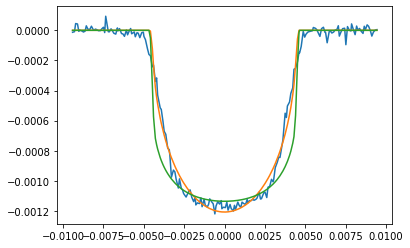

In [43]:
PATH = '../../processed_directories/go_circles/find_circles_rel/'
el = '004349452_1.csv'

df = pd.read_csv(PATH+el)

flux = np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))])
phase = np.array([ x for x in df['phase_l'] if(not(np.isnan(x)))])

#some brute force shit
# uarr=np.linspace(0.1,2, 10)
# varr=np.linspace(0.1,0.9, 10)
# minpopt=[]
# mincov = 1000
# for u in uarr:
#     popt1,pcov1=curve_fit(new_plar_free2, phase, flux, bounds=([0,u-0.01*u,-0.1,10], [1,u+0.01*u,0.9,200]))
#     rchi = np.sum((flux/np.abs(min(flux)) - new_plar_free2(phase, *popt1)/np.abs(min(flux)))**2) / len(flux)
#     print(rchi)
#     if(rchi<mincov):
#         mincov = rchi
#         minpopt = popt1
minpopt,mincov=curve_fit(new_plar, phase, flux, bounds=([0,-0.1,0,10], [1,1,1,200]))


rchi = np.sum((flux/np.abs(min(flux)) - new_plar(phase, *minpopt)/np.abs(min(flux)))**2) / len(flux)
print(rchi)

plt.plot(phase, flux)
#print("fin:",np.trace(mincov))
plt.plot(phase, new_plar(phase, *minpopt))
plt.plot(phase, new_plar(phase, 0.031, 0.02,0.61, 70.9))
print(["{:.5f}".format(x) for x in minpopt])
plt.show()

Quick check on theoretical transit sims


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


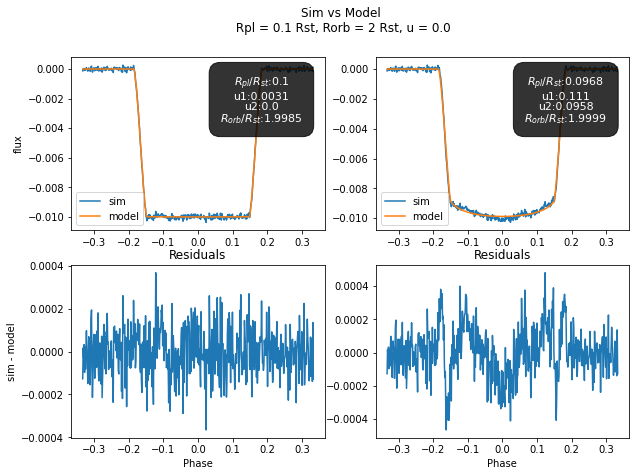

In [21]:
df = np.loadtxt('2d3d_0.1R_circ.csv', delimiter=' ')
np.random.seed(10000)
noise = np.random.normal(1,0.0001,len(df))
ph = df[:,0]/ np.pi
d2 = (df[:,1]*noise -1)
d3 = (df[:,2]*noise -1)
par2d, cov2d=curve_fit(new_plar_free2, ph, d2, bounds=([0,0,0,1], [1,.111,.11,np.inf]))
par3d, cov3d=curve_fit(new_plar_free2, ph, d3, bounds=([0,0,0,1], [1,.111,.11,np.inf]))
#print(["{:.5f}".format(x) for x in minpopt])

fig, ax = plt.subplots(2,2, figsize=(10,7))
plt.suptitle('Sim vs Model\n Rpl = 0.1 Rst, Rorb = 2 Rst, u = 0.0')

props = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
txt = "$R_{pl}$/$R_{st}$:"+str(np.round(par2d[0],4))+"\nu1:"+str(np.round(par2d[1],4
        ))+"\nu2:"+str(np.round(par2d[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(par2d[3],4))

props2 = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
txt2 = "$R_{pl}$/$R_{st}$:"+str(np.round(par3d[0],4))+"\nu1:"+str(np.round(par3d[1],4
        ))+"\nu2:"+str(np.round(par3d[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(par3d[3],4))


ax[0][1].text(0.75, 0.75, txt, fontsize=11,transform=ax[0][1].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=1, bbox=props, color='white')

ax[0][0].text(0.75, 0.75, txt2, fontsize=11,transform=ax[0][0].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=1, bbox=props2, color='white')    

ax[0][0].plot(ph, d3, label='sim')
ax[0][1].plot(ph, d2, label='sim')
ax[0][0].plot(ph, new_plar_free2(ph, *par3d), label='model')
ax[0][1].plot(ph, new_plar_free2(ph, *par2d), label='model')
ax[0][0].legend(loc='lower left')
ax[1][1].set_xlabel('Phase')
ax[1][0].set_xlabel('Phase')
ax[1][0].set_ylabel('sim - model')
ax[0][0].set_ylabel('flux')
ax[0][1].legend(loc='lower left')
ax[1][0].set_title('Residuals')
ax[1][1].set_title('Residuals')
ax[1][0].plot(ph, d3-new_plar_free2(ph, *par3d))
ax[1][1].plot(ph, d2-new_plar_free2(ph, *par2d))

#plt.savefig('th_sim_fit_0.1R_n2.jpg')



Some labour work...

In [8]:
fins = os.listdir('../../processed_directories/go_circles/plots_rel/')
takeout1 = os.listdir('../../processed_directories/go_circles/fit_circles_rel/')
takeout2 = os.listdir('../../processed_directories/go_circles/temp/')

for el in fins:
    loc = np.where(np.asarray(takeout2)==el[:11])[0]
    #print(loc)

    if(len(loc)>0):
        store1 = pd.HDFStore('../../processed_directories/go_circles/temp/'+el[:11])
        df1 = store1['data']
        metadata = store1.get_storer('data').attrs.metadata
        metadata['method']='pm'
        print(metadata)

        store2 = pd.HDFStore('../../processed_directories/go_circles/final_fits/'+el[:11])
        
        data = store1['data']

        store2.put('data', data)
        store2.get_storer('data').attrs.metadata = metadata
        store2.close()
        store1.close()
    
    

{'attr': array([3.29230051e-02, 9.00696595e-02, 5.47892616e-01, 6.47363928e+01]), 'var': 2.644814987770835, 'method': 'pm'}
{'attr': array([2.38264469e-02, 7.43818160e-01, 6.00807603e-01, 1.45076890e+02]), 'var': 5.142582270446718, 'method': 'pm'}
{'attr': array([2.98466589e-02, 4.78084380e-01, 8.58019778e-01, 8.19425678e+01]), 'var': 17.906615558303514, 'method': 'pm'}
{'attr': array([2.39727020e-02, 9.80225046e-01, 9.89279328e-01, 6.33352435e+01]), 'var': 3.673120890133843, 'method': 'pm'}
{'attr': array([ 2.15473915e-02, -3.20394382e-01,  3.66337466e-01,  1.52385089e+02]), 'var': 3.653815802286087, 'method': 'pm'}
{'attr': array([1.06318254e-02, 8.42129344e-01, 9.47530784e-01, 1.53429408e+02]), 'var': 35.46483544460005, 'method': 'pm'}
{'attr': array([2.18086557e-02, 9.95701994e-01, 3.24662125e-01, 1.30337373e+02]), 'var': 60.9321122317344, 'method': 'pm'}
{'attr': array([1.23349631e-02, 9.98689508e-01, 7.97118091e-01, 1.30145874e+02]), 'var': 82.57551946791568, 'method': 'pm'}
{'at

In [9]:
takeout = os.listdir('../../processed_directories/go_circles/find_circles_rel/')
takin = os.listdir('../../processed_directories/go_circles/final_fits/')
problist=[]

for el in takeout:
    if(np.any(np.array(takin)==el[:11])):
        continue
    else: problist.append(el[:11])

np.savetxt('../../processed_directories/go_circles/problem_nonfits',problist,delimiter=' ',fmt="%s")
    
